## Imports / CSV

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Concatenate
import seaborn as sns

### Target variable 'class' depicts the identification of a celestial body based on image. Thee classes are galaxy, star, or quasar.

In [5]:
df = pd.read_csv('D:\GIT\classification_project\Personal Projects\star_classification.csv')
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470



    obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
    alpha = Right Ascension angle (at J2000 epoch)
    delta = Declination angle (at J2000 epoch)
    u = Ultraviolet filter in the photometric system
    g = Green filter in the photometric system
    r = Red filter in the photometric system
    i = Near Infrared filter in the photometric system
    z = Infrared filter in the photometric system
    run_ID = Run Number used to identify the specific scan
    rereun_ID = Rerun Number to specify how the image was processed
    cam_col = Camera column to identify the scanline within the run
    field_ID = Field number to identify each field
    spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
    class = object class (galaxy, star or quasar object)
    redshift = redshift value based on the increase in wavelength
    plate = plate ID, identifies each plate in SDSS
    MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
    fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [6]:
#some columns depict id values which will create bias if use din the model
df = df.drop(['obj_ID', 'run_ID','rerun_ID','cam_col', 'field_ID','spec_obj_ID','fiber_ID'], axis = 1)
df

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187
...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000,9374,57749
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895,7626,56934
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366,2764,54535
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040,6751,56368


In [7]:
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

## Train Test Split before Data Cleaning

In [8]:
#separating the classes within the target variable to be used for classificaiton neural network.
df_encoded = pd.get_dummies(df, columns=['class'])
df_encoded

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,class_GALAXY,class_QSO,class_STAR
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354,True,False,False
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158,True,False,False
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592,True,False,False
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039,True,False,False
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374,57749,True,False,False
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626,56934,True,False,False
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764,54535,True,False,False
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751,56368,True,False,False


In [9]:
#changing each class to 1 if true 0 if false
df_encoded[['class_GALAXY','class_QSO','class_STAR']] = df_encoded[['class_GALAXY','class_QSO','class_STAR']].astype(int)
df_encoded

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,class_GALAXY,class_QSO,class_STAR
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354,1,0,0
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158,1,0,0
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592,1,0,0
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039,1,0,0
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374,57749,1,0,0
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626,56934,1,0,0
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764,54535,1,0,0
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751,56368,1,0,0


## Confusion

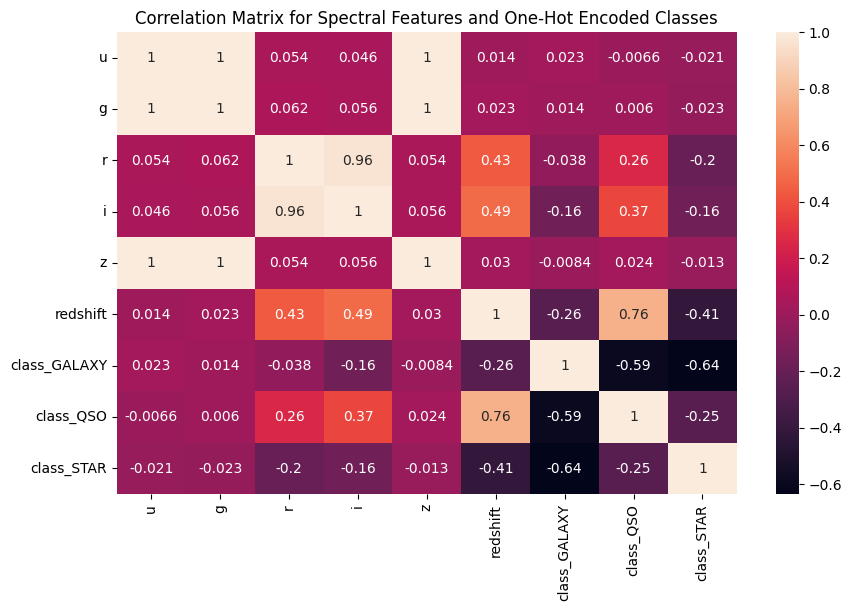

In [ ]:
spectral_columns = ['u', 'g', 'r', 'i', 'z', 'redshift']
correlation_matrix = df_encoded[spectral_columns + ['class_GALAXY', 'class_QSO', 'class_STAR']].corr()

correlation_matrix

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix for Spectral Features and One-Hot Encoded Classes')
plt.show()

## Train/Test

In [11]:
#making target all 3 columns
X = df_encoded.drop(['class_GALAXY','class_QSO','class_STAR'], axis = 1)
y = df_encoded[['class_GALAXY','class_QSO','class_STAR']]

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, stratify = y)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((75000, 10), (25000, 10), (75000, 3), (25000, 3))

## Data Cleaning

In [13]:
xtrain.isna().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
redshift    0
plate       0
MJD         0
dtype: int64

In [14]:
xtrain

,alpha,delta,u,g,r,i,z,redshift,plate,MJD
74343,225.874862,42.727752,21.89889,21.93462,21.74051,21.50444,21.14284,1.949017,8522,58193
74779,142.487231,42.540180,22.65515,23.28892,20.86813,19.64410,18.93083,0.694538,4638,55956
3308,353.558192,25.842754,21.98005,21.67045,21.37601,21.37836,20.88312,0.995883,7701,57356
42903,206.533427,3.099757,20.02118,18.35948,17.43377,17.08511,16.77380,0.108257,530,52026
61978,252.159767,37.823975,19.34463,18.47527,18.21787,18.13430,18.07734,-0.000788,5198,55823
...,...,...,...,...,...,...,...,...,...,...
34415,184.892323,51.131775,20.76693,20.61432,20.40339,20.32471,20.13474,0.945174,8226,57423
99756,171.851445,1.957733,23.32153,23.23948,21.30362,20.21201,19.86465,0.523948,4730,55630
38432,134.216472,10.843703,21.21439,19.95305,19.31892,19.09117,18.94786,0.001215,2671,54141
47622,359.454362,8.547484,21.92979,20.52814,18.86529,18.26697,17.84020,0.406460,6152,56164


In [15]:
ytrain

,class_GALAXY,class_QSO,class_STAR
74343,0,1,0
74779,1,0,0
3308,0,1,0
42903,1,0,0
61978,0,0,1
...,...,...,...
34415,0,1,0
99756,1,0,0
38432,0,0,1
47622,1,0,0


## Scaling

In [16]:
#simple scaling for data prep
xtrain = pd.DataFrame(MinMaxScaler().fit_transform(xtrain), columns = xtrain.columns)
xtrain

,alpha,delta,u,g,r,i,z,redshift,plate,MJD
0,0.627419,0.604338,0.554443,0.568727,0.603472,0.530821,0.583191,0.279010,0.672258,0.899099
1,0.395780,0.602495,0.592902,0.636076,0.559300,0.448765,0.471312,0.100340,0.355997,0.593665
2,0.982106,0.438451,0.558571,0.555590,0.585016,0.525260,0.570055,0.143259,0.605407,0.784817
3,0.573691,0.215011,0.458954,0.390937,0.385407,0.335892,0.362213,0.016839,0.021497,0.057073
4,0.700435,0.556161,0.424549,0.396695,0.425108,0.382170,0.428144,0.001308,0.401596,0.575505
...,...,...,...,...,...,...,...,...,...,...
74995,0.513575,0.686904,0.496879,0.503069,0.535769,0.478785,0.532203,0.136037,0.648156,0.793965
74996,0.477349,0.203791,0.626790,0.633617,0.581350,0.473814,0.518543,0.076044,0.363488,0.549153
74997,0.372805,0.291092,0.519634,0.470185,0.480858,0.424376,0.472173,0.001593,0.195831,0.345849
74998,0.998485,0.268533,0.556015,0.498784,0.457889,0.388022,0.416150,0.059310,0.479277,0.622064


In [17]:
xtest = pd.DataFrame(MinMaxScaler().fit_transform(xtest), columns = xtest.columns)
xtest

,alpha,delta,u,g,r,i,z,redshift,plate,MJD
0,0.894404,0.252018,0.998968,0.998917,0.528652,0.374854,0.998983,0.048020,0.310968,0.524850
1,0.007660,0.111992,0.998936,0.998948,0.634180,0.502910,0.999266,0.000943,0.560459,0.680639
2,0.031436,0.268370,0.999255,0.999111,0.643489,0.443032,0.999069,0.000982,0.877860,0.930639
3,0.373556,0.614082,0.998635,0.998635,0.436309,0.312550,0.998882,0.011633,0.051380,0.136128
4,0.606582,0.658690,0.999273,0.999014,0.593501,0.426770,0.999070,0.067070,0.526423,0.652239
...,...,...,...,...,...,...,...,...,...,...
24995,0.504294,0.810885,0.998641,0.998662,0.446183,0.316778,0.998885,0.017210,0.027115,0.096805
24996,0.523187,0.570328,0.999139,0.999235,0.639292,0.438773,0.999084,0.089203,0.301360,0.559257
24997,0.641253,0.362604,0.998801,0.998715,0.432783,0.296865,0.998832,0.027114,0.205846,0.399918
24998,0.422326,0.490288,0.999041,0.999157,0.635970,0.445046,0.999112,0.091682,0.504438,0.644593


### My main focus of this project is to see how a nueral network model will do, and be able to tweak it to increase the score.

In [18]:
#sequential modelling
model = Sequential()
model.add(Dense(64, input_dim = 10, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation = 'sigmoid'))

d:\GIT\classification_project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam')
model.fit(xtrain, ytrain, epochs = 50, batch_size = 1000, validation_data = [xtest, ytest])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6057 - val_loss: 0.5484
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4877 - val_loss: 0.5839
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4000 - val_loss: 0.5968
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3488 - val_loss: 0.6425
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3049 - val_loss: 0.6104
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2577 - val_loss: 0.6063
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2146 - val_loss: 0.5959
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1910 - val_loss: 0.6461
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1701 - val_loss: 0.7334
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1591 - val_loss: 0.7096
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1479 - val_loss: 0.8154
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1381 - val_lo

In [20]:
pred = model.predict(xtest)

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


## Prediction Overview

In [21]:
pred

array([[9.9996704e-01, 4.0772040e-05, 8.2562002e-10],
       [6.4214882e-03, 2.3190088e-07, 9.9332929e-01],
       [8.5085509e-03, 1.6496685e-07, 9.9022508e-01],
       ...,
       [9.9906772e-01, 7.4906147e-06, 3.3128024e-05],
       [9.9990577e-01, 1.2360208e-04, 3.6756651e-17],
       [6.2142074e-01, 5.6960547e-01, 0.0000000e+00]], dtype=float32)

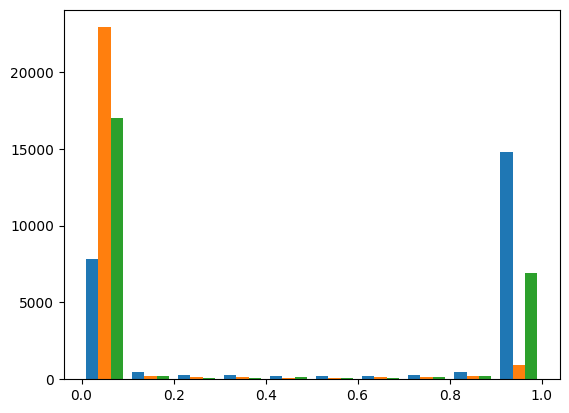

In [22]:
plt.hist(pred);

In [23]:
pred_df = pd.DataFrame(pred)
pred_df.columns = ['Galaxy','Quasar','Star']
pred_df

,Galaxy,Quasar,Star
0,0.999967,4.077204e-05,8.256200e-10
1,0.006421,2.319009e-07,9.933293e-01
2,0.008509,1.649668e-07,9.902251e-01
3,0.030712,5.109177e-08,9.699844e-01
4,0.999959,6.161581e-05,9.526673e-14
...,...,...,...
24995,0.443821,2.249597e-07,3.412968e-01
24996,0.999894,2.047547e-04,5.736756e-17
24997,0.999068,7.490615e-06,3.312802e-05
24998,0.999906,1.236021e-04,3.675665e-17


In [24]:
#finding argmax to classify each row
empty_list = []
for number in pred:
    empty_list.append(np.argmax(number))

In [25]:
#Series to show prediction value counts
pd.Series(empty_list).value_counts()

0    16019
2     7594
1     1387
Name: count, dtype: int64

## Scoring

In [26]:
auc_score = roc_auc_score(ytest, pred)
print("AUC Score: ", auc_score)

AUC Score:  0.9381898016704767
